In [19]:
from pandas import read_excel
from pandas import read_csv
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA_DEPRECATION_WARN
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas import DataFrame
from pandas import merge

In [20]:
#df = read_excel('http://itpaper.co.kr/data/kings.xlsx', engine='openpyxl')
df = read_csv('market-price.csv')
df.rename(columns={'market-price': 'age'}, inplace=True)
df['age'] = df['age'].astype('int')
df

,Timestamp,age
0,2020-06-30 00:00:00,9185
1,2020-07-01 00:00:00,9133
2,2020-07-02 00:00:00,9236
3,2020-07-03 00:00:00,9087
4,2020-07-04 00:00:00,9072
...,...,...
361,2021-06-26 00:00:00,31640
362,2021-06-27 00:00:00,32160
363,2021-06-28 00:00:00,34644
364,2021-06-29 00:00:00,34456


In [21]:
plt.rcParams["font.family"] = 'Malgun Gothic' # 한글 지원 폰트 설정
plt.rcParams["font.size"] = 18                # 기본 글자크기 설정
plt.rcParams["figure.figsize"] = (20, 10)     # 그래프 사이즈 (가로,세로)inch
plt.rcParams["axes.unicode_minus"] = False    # 유니코드 뺄셈기호 표시 사용 안함(깨짐방지)

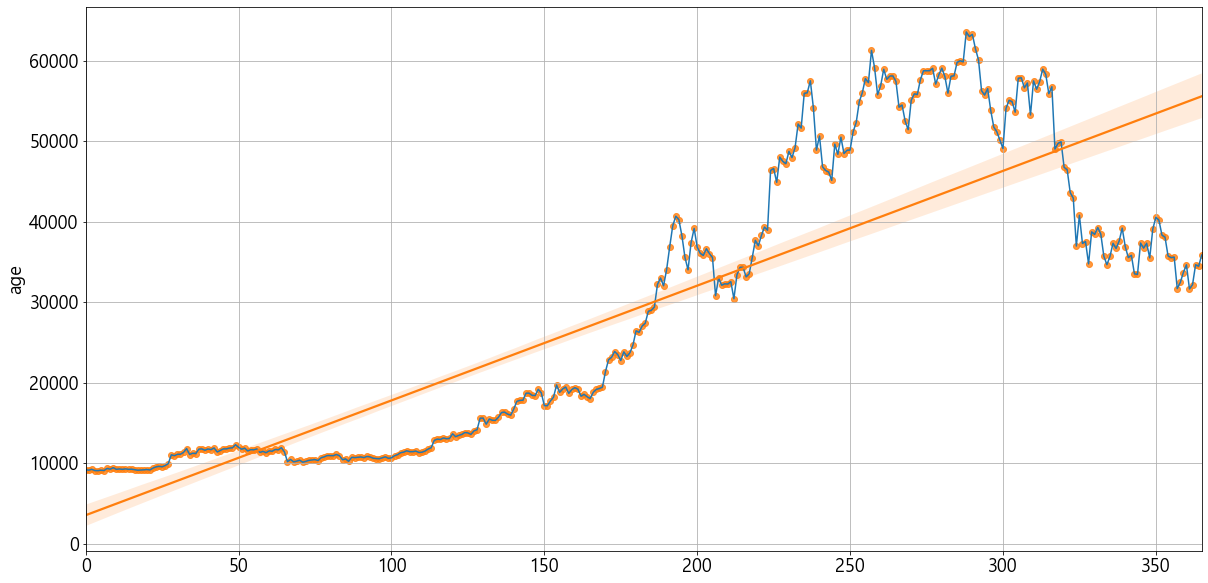

In [22]:
fig, ax = plt.subplots(1, 1)

sns.lineplot(x=df.index, y='age', data=df, ax=ax)
sns.regplot(x=df.index, y='age', data=df, ax=ax)
ax.grid()
plt.show()
plt.close()

### 평균이동법
- 구간별로 평균을 내서 시각화 하는 방법

In [23]:
df['2y'] = df['age'].rolling(window=2).mean()
df['3y'] = df['age'].rolling(window=3).mean()
df['5y'] = df['age'].rolling(window=5).mean()
df['8y'] = df['age'].rolling(window=8).mean()
df

,Timestamp,age,2y,3y,5y,8y
0,2020-06-30 00:00:00,9185,NaN,NaN,NaN,NaN
1,2020-07-01 00:00:00,9133,9159.0,NaN,NaN,NaN
2,2020-07-02 00:00:00,9236,9184.5,9184.666667,NaN,NaN
3,2020-07-03 00:00:00,9087,9161.5,9152.000000,NaN,NaN
4,2020-07-04 00:00:00,9072,9079.5,9131.666667,9142.6,NaN
...,...,...,...,...,...,...
361,2021-06-26 00:00:00,31640,33139.5,33317.666667,32817.2,33866.375
362,2021-06-27 00:00:00,32160,31900.0,32813.000000,32912.0,33420.250
363,2021-06-28 00:00:00,34644,33402.0,32814.666667,33351.4,33310.250
364,2021-06-29 00:00:00,34456,34550.0,33753.333333,33507.8,33168.250


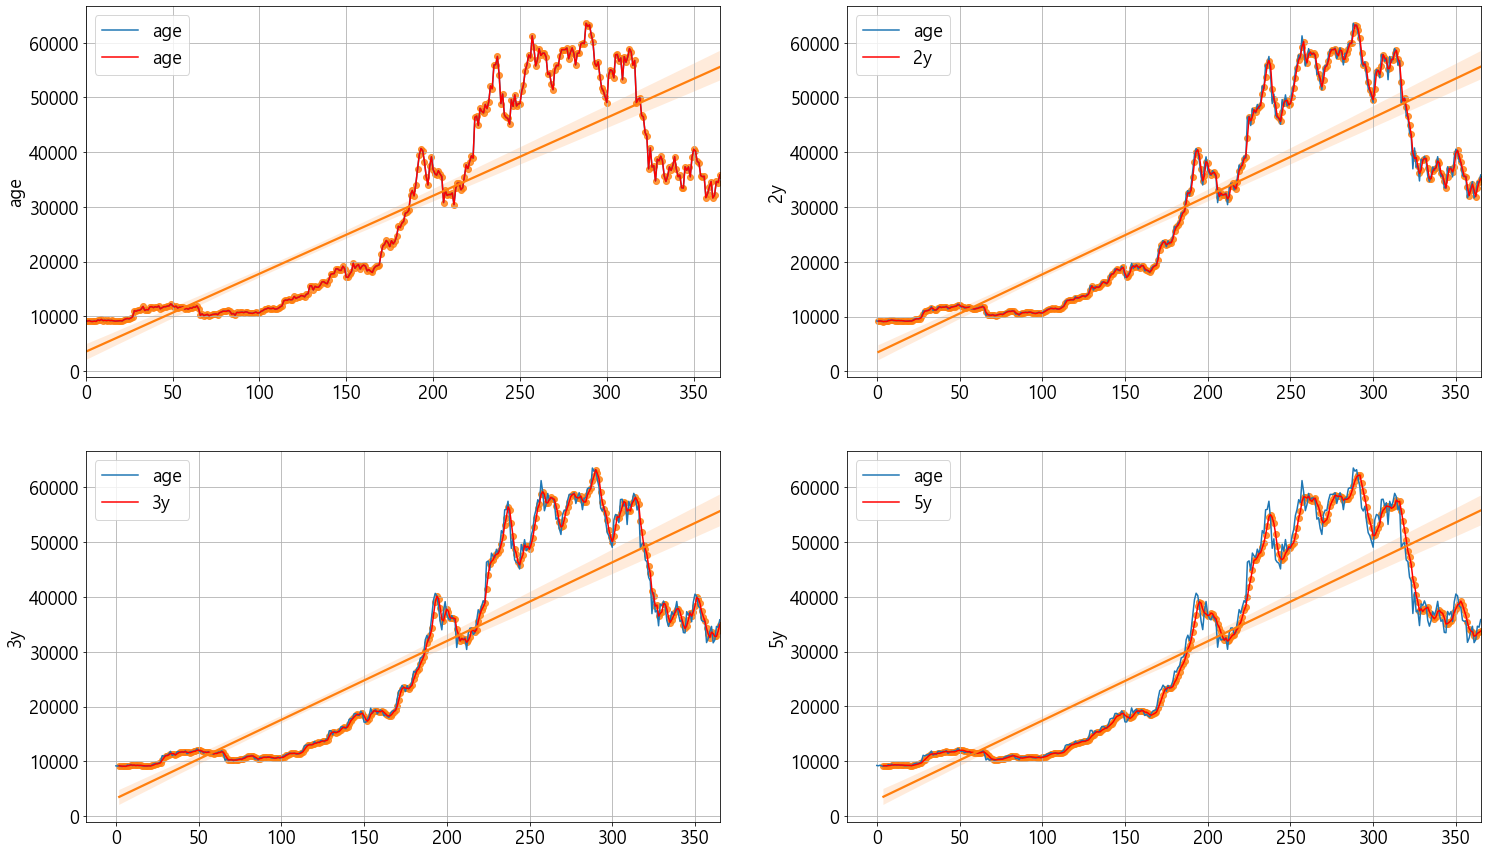

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(25, 15))

k = 1
for i in range(0, 2):
    for j in range(0, 2):
        sns.lineplot(x=df.index, y='age', data=df, label='age', ax=ax[i][j])
        sns.lineplot(x=df.index, y=df.columns[k], data=df, label=df.columns[k], color='red', ax=ax[i][j])
        sns.regplot(x=df.index, y=df.columns[k], data=df, ax=ax[i][j])
        ax[i][j].grid()
        ax[i][j].legend()
        k+=1

plt.show()
plt.close()

## ARIMA 모델 적용
### 데이터 정상화
ARIMA 모델은 정상성 시계열에 한해 사용한다 .

- 비정상 시계열 자료는 차분해 정상성으로 만족하는 조건의 시계열로 바꿔준다 .-
- 이전 그래프에서 평균이 시간에 따라 일정치 않은 모습을 보이므로 비정상시계열이다 .
따라서 차분을 진행한다 .

- 1차 차분 결과에서 평균과 분산이 시간에 따라 의존하지 않음을 확인한다 .
- ARIMA(p, 1, q)모델이며 차분을 1번 해야 정상성을 만족한다.

In [38]:
king_ff1 = np.diff(df['age'], 1)
king_ff1

array([  -52,   103,  -149,   -15,    59,   -42,   259,   -92,   184,
        -202,    49,   -52,    60,   -57,    16,   -61,   -62,    23,
          20,    40,   -51,   229,   145,    76,   -62,   156,   231,
        1104,  -108,   168,    12,   229,   480,  -746,   165,   -48,
         556,    22,  -167,   162,   -83,   209,  -501,   181,   204,
          -3,    99,    41,   379,  -324,  -235,   131,  -343,   161,
         -30,   110,  -426,   130,  -165,   232,   -53,   226,   -48,
         264,  -526, -1210,   280,  -308,    95,   113,  -246,   106,
         125,    43,    51,  -116,   344,   111,   163,    -5,   -12,
         150,  -162,  -489,   102,  -298,   498,   -40,    40,    42,
         -82,   148,   -63,  -158,   -44,   -24,   122,   115,  -185,
          67,   253,   140,   239,    74,   164,  -112,     3,    72,
        -176,    39,   142,   250,   167,   906,   159,   -46,   184,
         -92,    40,   575,  -362,   169,   106,   246,   -52,  -183,
         448,   132,

In [39]:
king_ff2 = np.diff(df['age'], 2)
king_ff2

array([  155,  -252,   134,    74,  -101,   301,  -351,   276,  -386,
         251,  -101,   112,  -117,    73,   -77,    -1,    85,    -3,
          20,   -91,   280,   -84,   -69,  -138,   218,    75,   873,
       -1212,   276,  -156,   217,   251, -1226,   911,  -213,   604,
        -534,  -189,   329,  -245,   292,  -710,   682,    23,  -207,
         102,   -58,   338,  -703,    89,   366,  -474,   504,  -191,
         140,  -536,   556,  -295,   397,  -285,   279,  -274,   312,
        -790,  -684,  1490,  -588,   403,    18,  -359,   352,    19,
         -82,     8,  -167,   460,  -233,    52,  -168,    -7,   162,
        -312,  -327,   591,  -400,   796,  -538,    80,     2,  -124,
         230,  -211,   -95,   114,    20,   146,    -7,  -300,   252,
         186,  -113,    99,  -165,    90,  -276,   115,    69,  -248,
         215,   103,   108,   -83,   739,  -747,  -205,   230,  -276,
         132,   535,  -937,   531,   -63,   140,  -298,  -131,   631,
        -316,  1304,

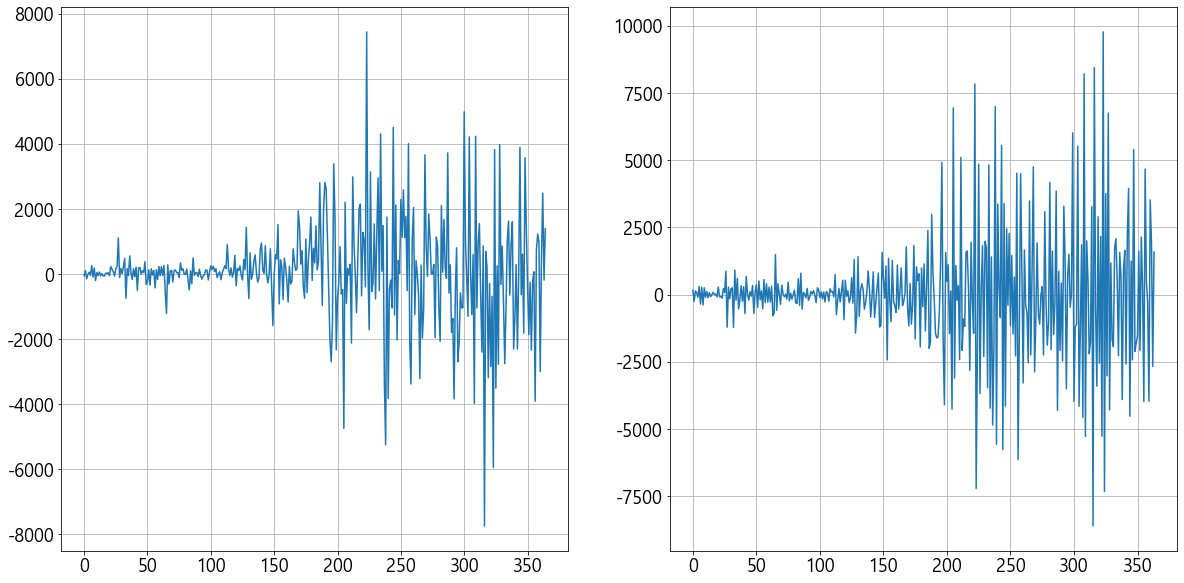

In [40]:
king_ff = [king_ff1, king_ff2]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i in range(0, len(king_ff)):
    ax[i].plot(king_ff[i])
    ax[i].grid()

plt.show()
plt.close()

In [28]:
model = ARIMA(df['age'], (0, 1, 1))
fit = model.fit()

print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.age   No. Observations:                  365
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3197.557
Method:                       css-mle   S.D. of innovations           1542.994
Date:                Wed, 30 Jun 2021   AIC                           6401.113
Time:                        15:32:31   BIC                           6412.813
Sample:                             1   HQIC                          6405.763
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          73.0454     73.497      0.994      0.320     -71.007     217.097
ma.L1.D.age    -0.0902      0.048     -1.895      0.058      -0.184       0.003
                                    Roots       

c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [29]:
model = ARIMA(df['age'], (1, 1, 0))
fit = model.fit()

print(fit.summary())

c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.age   No. Observations:                  365
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3197.265
Method:                       css-mle   S.D. of innovations           1541.755
Date:                Wed, 30 Jun 2021   AIC                           6400.531
Time:                        15:32:31   BIC                           6412.230
Sample:                             1   HQIC                          6405.180
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          73.0466     73.012      1.000      0.317     -70.054     216.147
ar.L1.D.age    -0.1056      0.052     -2.029      0.042      -0.208      -0.004
                                    Roots       

## 정상성 검정 (ADF 검정, 시계열 안정성 테스트)
n회의 차분을 수행하여 시계열이 안정화 되는지 찾는 방법

In [42]:
def my_adf_test(dataset):
    result = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",result[0])
    print("2. P-Value : ", result[1])
    print("3. Num Of Lags : ", result[2])
    print("4. Num Of Observations Used For ADF Regression:",result[3])
    print("5. Critical Values :")
    
    cv = {}
    for key, val in result[4].items():
        print("\t",key, ": ", val)
        cv[key] = val
        
    #if result[0] < cv['1%'] and result[1] < 0.01:
    if result[0] < cv['5%'] and result[1] < 0.05:
    #if result[0] < cv['10%'] and result[1] < 0.1:
        print("[O] 시계열이 안정적임")
    else:
        print("[X] 시계열이 안정적이지 않음")

In [43]:
my_adf_test(df['age'])

1. ADF :  -1.2073358243741465
2. P-Value :  0.6704320911144482
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression: 353
5. Critical Values :
	 1% :  -3.4490114443793214
	 5% :  -2.8697627072503757
	 10% :  -2.5711506161673716
[X] 시계열이 안정적이지 않음


In [44]:
aa_model = auto_arima(df['age'], start_p=0,start_q=0,max_p=3,max_q=3,trace=True,suppress_warnings=True,stepwise=False,seasonal=False)
aa_model.fit(df['age'])

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6402.625, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6401.211, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6400.293, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6401.381, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6400.641, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6401.856, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6401.405, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6403.258, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6400.825, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6401.854, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6403.287, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6405.038, Time=0.42 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6401.227, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6403.084, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6405.122, Time=0.24 sec

Best mode

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True)

In [45]:
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(df['age'], order=aa_model.order)

# 이 객체를 통해 시계열 분석의 예측데이터를 얻을 수 있다.
fit = model.fit()

print(fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.age   No. Observations:                  365
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3195.976
Method:                       css-mle   S.D. of innovations           1536.287
Date:                Wed, 30 Jun 2021   AIC                           6399.952
Time:                        15:36:50   BIC                           6415.552
Sample:                             1   HQIC                          6406.152
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          73.0466     79.092      0.924      0.356     -81.972     228.065
ma.L1.D.age    -0.1089      0.053     -2.066      0.039      -0.212      -0.006
ma.L2.D.age     0.0927      0.052      1.781    

In [46]:
s = df.index.max()+1
e = s + 15
idx = list(range(s, e))

# 학습 데이터로부터 15단계 후를 예측
fc, se, conf = fit.forecast(15, alpha=0.05) # 유의수준 5%
fc_df = DataFrame(fc, index=idx).rename(columns={0:'예상수명'})
fc_df

,예상수명
366,35806.335590
367,35978.674624
368,36051.721200
369,36124.767775
370,36197.814350
371,36270.860926
372,36343.907501
373,36416.954076
374,36490.000652
375,36563.047227


In [47]:
conf_df = DataFrame(conf, index=idx).rename(columns={0:'최소', 1:'최대'})
conf_df

,최소,최대
366,32795.269320,38817.401859
367,31945.600550,40011.748698
368,31047.664079,41055.778320
369,30309.659105,41939.876445
370,29671.683030,42723.945671
371,29103.902631,43437.819220
372,28588.896710,44098.918292
373,28115.442555,44718.465598
374,27675.807851,45304.193452
375,27264.397008,45861.697446


In [48]:
예측df = merge(fc_df, conf_df, left_index=True, right_index=True)
예측df

,예상수명,최소,최대
366,35806.335590,32795.269320,38817.401859
367,35978.674624,31945.600550,40011.748698
368,36051.721200,31047.664079,41055.778320
369,36124.767775,30309.659105,41939.876445
370,36197.814350,29671.683030,42723.945671
371,36270.860926,29103.902631,43437.819220
372,36343.907501,28588.896710,44098.918292
373,36416.954076,28115.442555,44718.465598
374,36490.000652,27675.807851,45304.193452
375,36563.047227,27264.397008,45861.697446


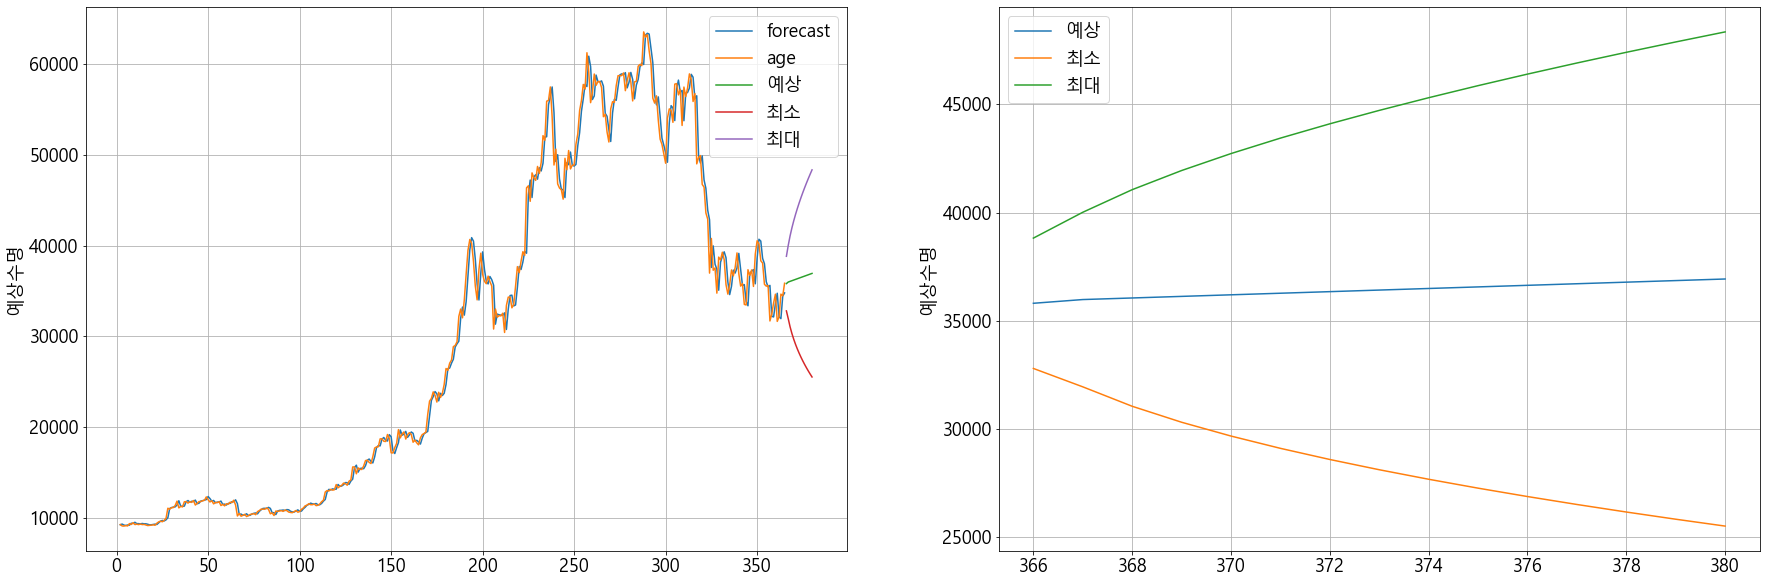

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

fit.plot_predict(ax=ax[0])
sns.lineplot(x=fc_df.index, y='예상수명', label='예상', data=예측df, ax=ax[0])
sns.lineplot(x=fc_df.index, y='최소', label='최소', data=예측df, ax=ax[0])
sns.lineplot(x=fc_df.index, y='최대', label='최대', data=예측df, ax=ax[0])

sns.lineplot(x=fc_df.index, y='예상수명', label='예상', data=예측df, ax=ax[1])
sns.lineplot(x=fc_df.index, y='최소', label='최소', data=예측df, ax=ax[1])
sns.lineplot(x=fc_df.index, y='최대', label='최대', data=예측df, ax=ax[1])

ax[0].grid()
ax[1].grid()
plt.show()